In [2]:
import pandas_datareader.data as web
from pandas import Series,DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import statsmodels.tsa.stattools as ts

import pywt

/root/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
%matplotlib inline

In [4]:
import datetime

In [5]:
start = datetime.datetime(2015,11,1)
end = datetime.datetime(2016,12,15)

f = web.DataReader("F", "yahoo", start, end)

In [6]:
test = f[f.index < '2016-12-1']['Close']


/root/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(160.54339976963672, 201.82603823493108, 177.31923627355522)


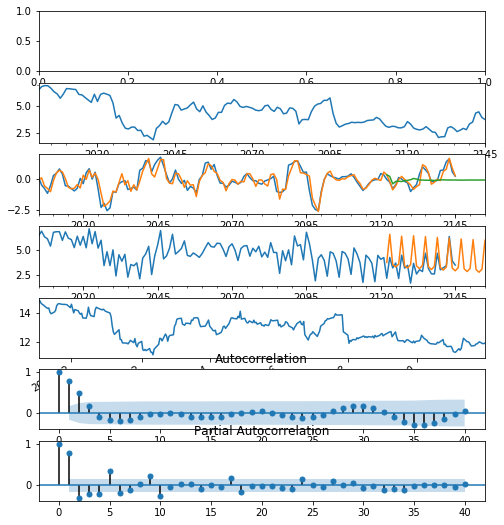

In [50]:
fig = plt.figure(figsize=(8, 10))
ax = {}

for i in range(7):
    ax[i+1] = fig.add_subplot('71'+str(i+1))
test.plot(ax=ax[5])

Data = f.drop(['Adj Close'], axis=1)

close = pywt.dwt(f['Close'], 'db4')

Close_db4=pd.Series(close[0])
Close_db4=Close_db4-14
Close_db4.index = pd.Index(sm.tsa.datetools.dates_from_range('2001','2145'))
Close_db4.plot(ax=ax[2])


Close=Close_db4.diff(4)
Close = Close[4:]
Close.plot(ax=ax[3])

sm.graphics.tsa.plot_acf(Close,lags=40,ax=ax[6]) #ARIMA,q
sm.graphics.tsa.plot_pacf(Close,lags=40,ax=ax[7]) #ARIMA,p

ts.adfuller(Close,4)

Arma = sm.tsa.ARMA(Close,order=(9,3)).fit(disp=-1, method='mle')
print(Arma.aic,Arma.bic,Arma.hqic)

Arma_stock=Arma.predict()
Arma_stock.plot(ax=ax[3])

predict_stock = Arma.predict('2122','2155',dynamic=True)
predict_stock.plot(ax=ax[3])

L=len(Arma_stock)
i=0
while i<L:
    if(i<4):
        Arma_stock[i]=Arma_stock[i]+Close_db4[i]
    else:
        Arma_stock[i] = Arma_stock[i]+Arma_stock[i-4]
    i=i+1
Arma_stock.plot(ax=ax[4])


L=len(predict_stock)
i=0
while i<L:
    if(i<4):
        predict_stock[i] = predict_stock[i]+Arma_stock[-4+i]
    else:
        predict_stock[i] = predict_stock[i]+predict_stock[i-4]
    i=i+1
predict_stock.plot(ax=ax[4])

In [1]:
from __future__ import print_function
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

%matplotlib inline

/root/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [28]:
dta = sm.datasets.sunspots.load_pandas().data

In [33]:
dta.index = pd.to_datetime(dta['YEAR'].astype(int), format='%Y')

In [34]:
dta = dta.drop('YEAR', axis=1)
dta.head()

,SUNACTIVITY
YEAR,
1700-01-01 00:00:00,5.0
1701-01-01 00:00:00,11.0
1702-01-01 00:00:00,16.0
1703-01-01 00:00:00,23.0
1704-01-01 00:00:00,36.0


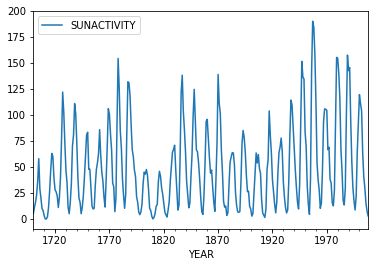

In [35]:
dta.plot()

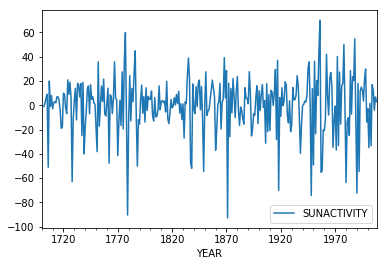

In [36]:
dta.diff(1).diff(1).plot()

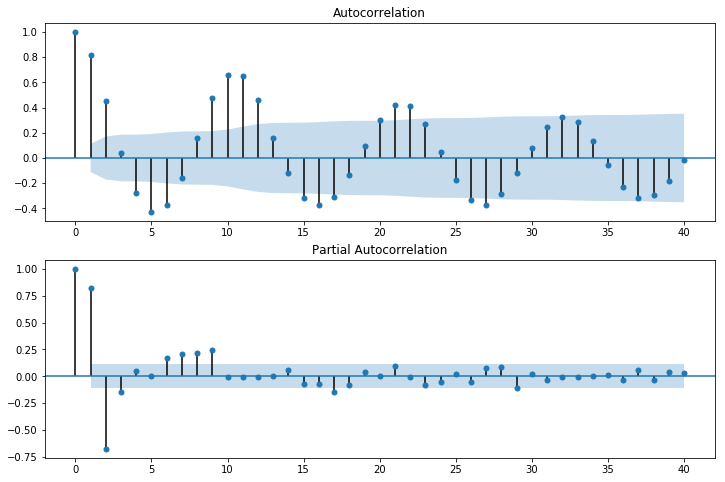

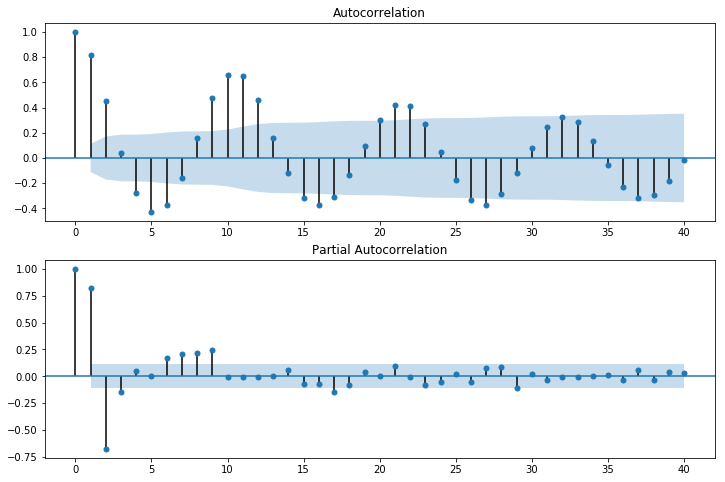

In [37]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(dta.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(dta.values, lags=40, ax=ax2)

In [40]:
arma_mod20 = sm.tsa.ARMA(dta, (2,0)).fit()
print(arma_mod20.params)
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

const                49.659374
ar.L1.SUNACTIVITY     1.390656
ar.L2.SUNACTIVITY    -0.688571
dtype: float64
2622.63633806 2637.56970317 2628.60672591


In [41]:
arma_mod30 = sm.tsa.ARMA(dta, (3,0)).fit()
print(arma_mod30.params)
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)

const                49.749873
ar.L1.SUNACTIVITY     1.300810
ar.L2.SUNACTIVITY    -0.508093
ar.L3.SUNACTIVITY    -0.129649
dtype: float64
2619.4036287 2638.07033508 2626.8666135


In [42]:
sm.stats.durbin_watson(arma_mod30.resid.values)

1.9564814002571953

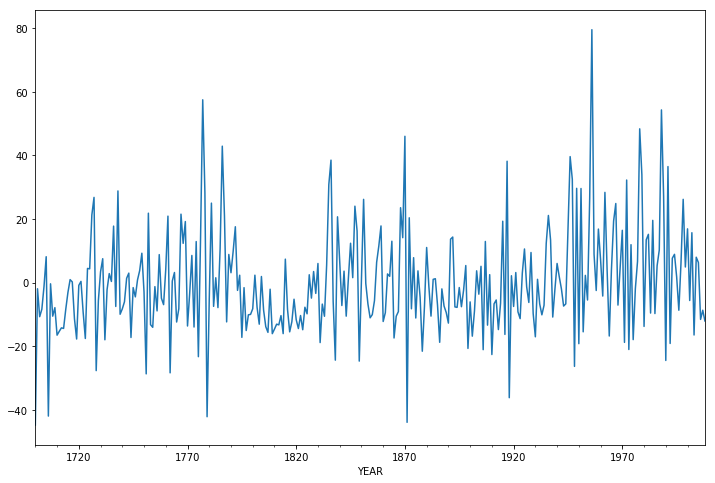

In [43]:
fig = plt.figure(figsize=(12,8))
arma_mod30.resid.plot();

In [70]:
resid = arma_mod30.resid
stats.normaltest( resid )

NormaltestResult(statistic=49.845004716319792, pvalue=1.5007029996843931e-11)

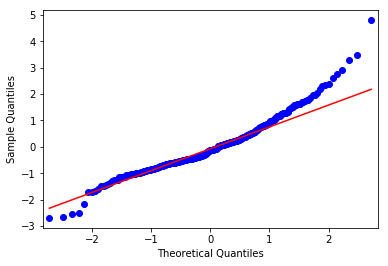

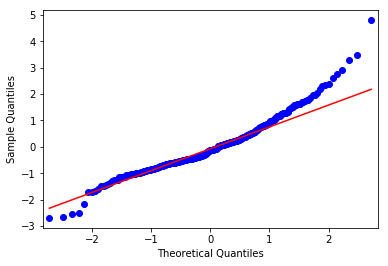

In [71]:
qqplot(resid, line='q', fit=True)

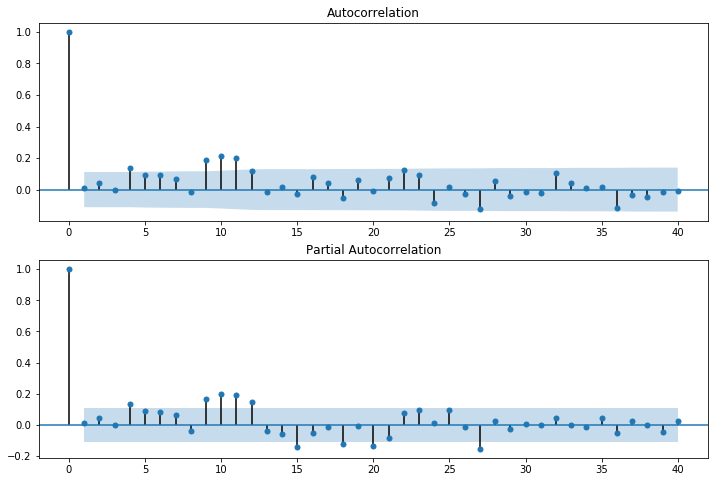

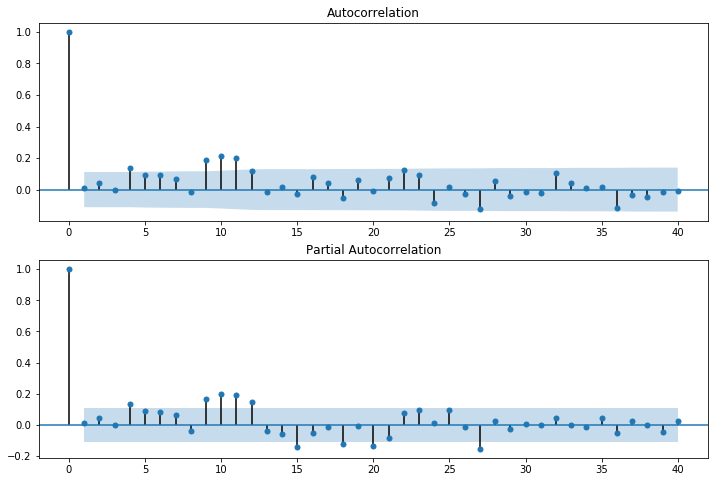

In [75]:
fig1 = plt.figure(figsize=(12,8))
ax11 = fig1.add_subplot(211)
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax11)
ax12 = fig1.add_subplot(212)
sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax12)

In [76]:
r,q,p = sm.tsa.acf(resid.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q      Prob(>Q)
lag                                    
1.0   0.009178   0.026285  8.712063e-01
2.0   0.041793   0.573037  7.508731e-01
3.0  -0.001335   0.573597  9.024492e-01
4.0   0.136089   6.408913  1.706208e-01
5.0   0.092468   9.111820  1.046863e-01
6.0   0.091948  11.793234  6.674370e-02
7.0   0.068748  13.297190  6.519008e-02
8.0  -0.015020  13.369219  9.976165e-02
9.0   0.187592  24.641891  3.393933e-03
10.0  0.213718  39.321963  2.229502e-05
11.0  0.201082  52.361094  2.344992e-07
12.0  0.117182  56.804138  8.574437e-08
13.0 -0.014055  56.868276  1.893940e-07
14.0  0.015398  56.945515  3.997737e-07
15.0 -0.024967  57.149270  7.741618e-07
16.0  0.080916  59.296723  6.872288e-07
17.0  0.041138  59.853692  1.110963e-06
18.0 -0.052021  60.747383  1.548458e-06
19.0  0.062496  62.041646  1.831674e-06
20.0 -0.010302  62.076934  3.381297e-06
21.0  0.074453  63.926606  3.193640e-06
22.0  0.124955  69.154719  8.978521e-07
23.0  0.093162  72.070981  5.799894e-07


In [86]:
predict_sunspots = arma_mod30.predict('1990-1-1', '2012-1-1', dynamic=True)
print(predict_sunspots)

1990-01-01    167.047409
1991-01-01    140.992981
1992-01-01     94.859078
1993-01-01     46.860848
1994-01-01     11.242515
1995-01-01     -4.721378
1996-01-01     -1.167007
1997-01-01     16.185594
1998-01-01     39.021792
1999-01-01     59.449793
2000-01-01     72.170080
2001-01-01     75.376735
2002-01-01     70.436417
2003-01-01     60.731545
2004-01-01     50.201749
2005-01-01     42.075970
2006-01-01     38.114219
2007-01-01     38.454567
2008-01-01     41.963735
2009-01-01     46.869207
2010-01-01     51.423185
2011-01-01     54.399649
2012-01-01     55.321628
Freq: AS-JAN, dtype: float64


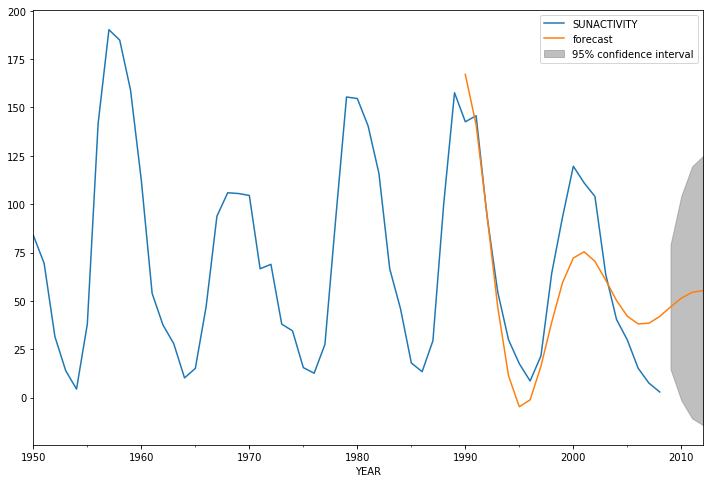

In [91]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = dta.loc['1950-1-1':].plot(ax=ax)
fig = arma_mod30.plot_predict('1990-1-1', '2012-1-1', dynamic=True, ax=ax, plot_insample=False)

In [92]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

In [93]:
mean_forecast_err(dta.SUNACTIVITY, predict_sunspots)

5.6370188608596505

In [ ]:
sm.tsa.AR(dta).select_order(40, 'aic') #29

In [ ]:
sm.tsa.MA.